# GPIM  Big Data Analytics: Project Group 14
---
Team members: Arturo Albarran, Joaquin Gana, Wilhelm Hartvig, & Sara Sanchez 

## Description and motivation

This project seeks to understand the main determinants of Airbnb listings price and activity in Mexico City and Santiago de Chile. Listings with higher levels of price and activity are of interested for regulators as they might have consequences in terms of tax revenue losses. The specific problem is to predict price and activity (separately) using features about the listing (for example: neighborhood). 

We provide Exploratory Data Analyses, Data Preparation and then apply machine learning tecniques to explain which variables classify prices and activity. We tune the model. For more details, please see the write up that accompanies this notebook. <br>
Data of scrapping: March, 2019.

#### This notebook focus in Mexico City.


## Table of contents
 
1. Load data and cleaning <br>
    1.1 Environment set up
    1.1 Load data and Pre-processing <br>
    1.2 Data cleaning <br>
2. Exploratory Data Analyses <br>
    2.1 Prices <br>
    2.2 Host joining Airbnb
    2.3 Bookings 
    2.4 Geospatial analysis <br>
    2.5 Airbnb features  <br>
        2.5.1 Room type
        2.5.2 Availability
        2.5.3 Listing per host
3. Data Preparation  <br> 
4. Model  <br>
    4.1 Price Analysis: Linear regression <br>
    4.2 Price Analysis: Tuned model, Random Forest regressor

## Market analysis: Mexico City.

## 1. Data Clean and Exploration

### 1.1 Environment set up

In [1]:
# Let's import the majority of the packages we are going to use in the project.
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

### This is to set pandas to display all rows and columns when asked
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# For the linear regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

import statsmodels.api as sm

# Colors sourced from here: https://usbrandcolors.com/airbnb-colors/
bnb_red = '#FF5A5F'
bnb_blue = '#00A699'
bnb_orange = '#FC642D'
bnb_lgrey = '#767676'
bnb_dgrey = '#484848'
bnb_maroon = '#92174D'

### 1.2 Load data and Pre-processing

In [2]:
#Loading data for Mexico City
raw_airbnb_Mexico = pd.read_csv('./listings_MexicoCity.csv', low_memory=False)
raw_airbnb_Mexico.shape
# Row: listings
# Columns: features of the listing

(17229, 106)

There are 17229 listings in the dataset. The whole dataset consider 106 features.

In [3]:
###Quick checks

#samples are rows (same as obs)
print("\nNumber of listings:", len(raw_airbnb_Mexico))
#printing number of columns (variables, features)
print("\nNumber of columns:", len(raw_airbnb_Mexico.columns))
#printing column names
print('Columns:\n', list(raw_airbnb_Mexico.columns))


Number of listings: 17229

Number of columns: 106
Columns:
 ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities

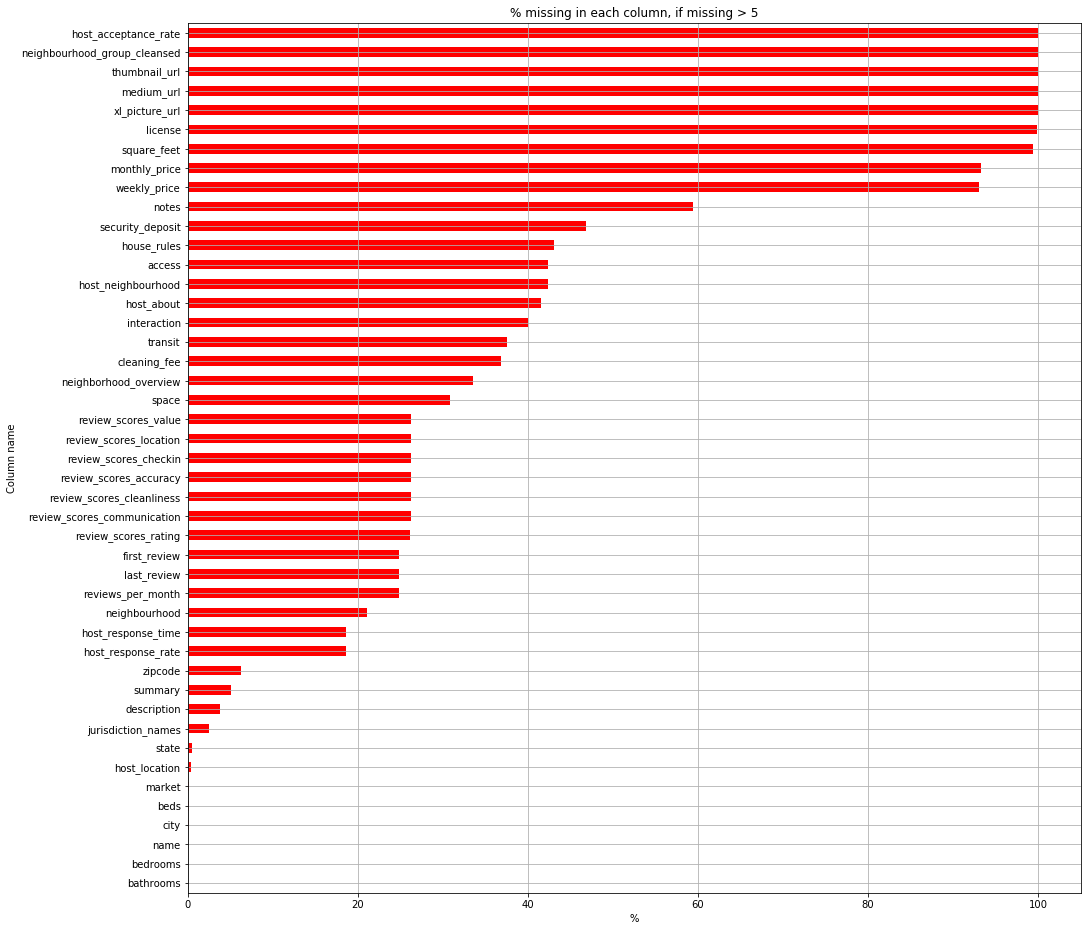

In [4]:
# Percent of each column with missing vaules = bad columns
has_na= raw_airbnb_Mexico.isna().sum().sort_values(ascending=True)
no_na = has_na[has_na ==0]
has_na = has_na[has_na > 5]
(has_na/len(raw_airbnb_Mexico)*100).plot(kind='barh', figsize=(16,16), color= "red", title='% missing in each column, if missing > 5', grid='x')
plt.xlabel('%')
plt.ylabel('Column name')
plt.show()

In [5]:
#general data info
raw_airbnb_Mexico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17229 entries, 0 to 17228
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(23), object(62)
memory usage: 13.9+ MB


The first step is to keep the relevant variables. First, we will drop text columns, as will other columns which are not useful for predicting price. 

In [6]:
# Do not drop host_id, host_name, host_total_listings_count yet
cols_drop = ['listing_url', 'scrape_id', 'experiences_offered','last_scraped', 'name', 'summary', 'space', 'description', 
             'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
             'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 
             'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
             'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'host_acceptance_rate',
             'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 
             'license', 'jurisdiction_names', 'latitude', 'longitude', 'street', 'neighbourhood', 
             'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact',
             'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
             'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
             'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_has_profile_pic',
             'host_identity_verified','bed_type', 'cleaning_fee','calendar_updated',
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location','requires_license', 'instant_bookable', 
             'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 
             'require_guest_phone_verification','has_availability']
airbnb_Mexico = raw_airbnb_Mexico.drop(cols_drop, axis=1)

In [7]:
# The new dataset
#samples are rows (same as obs)
print("\nNumber of listings:", len(airbnb_Mexico))
#printing number of columns (variables, features)
print("\nNumber of columns:", len(airbnb_Mexico.columns))
#printing column names
print('Columns:\n', list(airbnb_Mexico.columns))


Number of listings: 17229

Number of columns: 37
Columns:
 ['id', 'host_id', 'host_name', 'host_since', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'city', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'security_deposit', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [8]:
#Percent of dataset which is NA per column
round(airbnb_Mexico.isna().sum()/len(airbnb_Mexico)*100)

id                                               0.0
host_id                                          0.0
host_name                                        0.0
host_since                                       0.0
host_listings_count                              0.0
host_total_listings_count                        0.0
neighbourhood_cleansed                           0.0
city                                             0.0
zipcode                                          6.0
property_type                                    0.0
room_type                                        0.0
accommodates                                     0.0
bathrooms                                        0.0
bedrooms                                         0.0
beds                                             0.0
amenities                                        0.0
price                                            0.0
security_deposit                                47.0
guests_included                               

The new dataset includes 17229 observations and 38 variables. It's worth to mention that we still will drop more variables for our final model, but this it's a first draft for our final dataset.

Let's describe the main variables consider in our dataset.

### Variables description
* host_since - date that the host first joined Airbnb
* listings_count - how many listings the host has in total
* neighbourhood_cleansed - the Mexico city delegation the property is in
* room_type - type of listing, e.g. entire home, private room or shared room
* accommodates - how many people the property accommodates
* bathrooms - number of bathrooms
* bedrooms - number of bedrooms
* beds - number of beds
* amenities - list of amenities
* price - nightly advertised price (the target variable)
* guests_included - the number of guests included in the booking fee
* extra_people - the price per additional guest above the guests_included price
* minimum_nights - the minimum length of stay
* maximum_nights - the maximum length of stay
* availability_30 - how many nights are available to be booked in the next 30 days
* availability_60 - how many nights are available to be booked in the next 60 days
* availability_90 - how many nights are available to be booked in the next 90 days
* availability_365 - how many nights are available to be booked in the next 365 days
* number_of_reviews - the number of reviews left for the property
* number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
* first_review - the date of the first review
* review_scores_rating - guests can score properties overall from 1 to 5 stars
* review_scores_value - guests can score a booking's value for money from 1 to 5 stars
* reviews_per_month - calculated field of the average number of reviews left by guest each month

Our variable of analysis is price. Look at the distribution of the prices to get an idea of what the target that we are going to try to predict looks like. <br>
The price will be transformed to a numeric variable. It's currently a string. Also, we transform the price to US Dollars. ##(Exchange_rate, March 2019: 19.1343 pesos per dollar)

Despite the heavy left skew, log-transforming the prices almost completely normalizes the distribution.

### 1.3 Data Cleaning

There are a lot of columns in this dataset. We should only focus on cleaning those that we are interested in considering in the model.

* Convert strings to relevant formats
* Impute or remove missing data
* Simplify categorical variables with tons of values

#### Convert strings to datetime/float/etc¶


In [9]:
# Host since. An older host, might have more reviews, thus, it can charge a higher price.
# Converting to datetime
airbnb_Mexico.host_since = pd.to_datetime(airbnb_Mexico.host_since) 

# Calculating the number of days
airbnb_Mexico['host_since_num'] = (pd.datetime(2019, 12, 31) - airbnb_Mexico.host_since).astype('timedelta64[D]')

# Security deposit
airbnb_Mexico.security_deposit = airbnb_Mexico.security_deposit.str.replace(
    '$', '').str.replace(',', '').astype(float)

# Printing mean and median
print("Mean days as host:", round(airbnb_Mexico['host_since_num'].mean(),0))
print("Median days as host:", airbnb_Mexico['host_since_num'].median())

Mean days as host: 1378.0
Median days as host: 1319.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


#### Categorical/Ordinal variables¶


#### Room Type

In [10]:
airbnb_Mexico.room_type.value_counts()

Private room       8572
Entire home/apt    8309
Shared room         348
Name: room_type, dtype: int64

#### Room Type

In [11]:
# Create numerical column for room type
airbnb_Mexico['room_type_num'] = airbnb_Mexico.room_type.map({
    'Entire home/apt':
    2,
    'Private room':
    1,
    'Shared room':
    1
})



# One hot encode
room_type_dummies = pd.get_dummies(airbnb_Mexico.room_type,
                                   prefix='room')

# Merge with df
airbnb_Mexico = airbnb_Mexico.merge(room_type_dummies,
                                                    left_index=True,
                                                    right_index=True)

##### Neighbourhood
Create dummy variables by neighbourhood.

In [12]:
# Neighbourhood
# One hot encode
n_type_dummies = pd.get_dummies(airbnb_Mexico.neighbourhood_cleansed,
                                   prefix='neigh')

# # Merge with df
airbnb_Mexico = airbnb_Mexico.merge(n_type_dummies,
                                                    left_index=True,
                                                    right_index=True)

#### Property type

In [13]:
airbnb_Mexico['property_type'].unique()

array(['Apartment', 'Boutique hotel', 'Hostel', 'Villa',
       'Bed and breakfast', 'Condominium', 'Loft', 'House', 'Guesthouse',
       'Other', 'Serviced apartment', 'Guest suite', 'Tiny house',
       'Townhouse', 'Aparthotel', 'Bungalow', 'Cabin', 'Camper/RV',
       'Nature lodge', 'Chalet', 'Hotel', 'Cottage',
       'Casa particular (Cuba)', 'Resort', 'Farm stay',
       'Heritage hotel (India)', 'Barn', 'Bus', 'Boat', 'Earth house',
       'Dorm', 'Hut', 'In-law', 'Campsite', 'Tent', 'Dome house',
       'Treehouse', 'Cave', 'Cycladic house (Greece)'], dtype=object)

In [14]:
# Change the 15 most occuring property types to numric, in range 0-15
# The rest get put in "other"
property_dict = dict(zip(airbnb_Mexico["property_type"].value_counts().index[:15].to_list(), [i for i in range(15)]))

def apply_property_dict(prop_type):
    if prop_type in property_dict:
        return property_dict[prop_type]
    else:
        return property_dict["Other"]

    
airbnb_Mexico["property_type_num"] = airbnb_Mexico["property_type"].apply(apply_property_dict) 

In [15]:
list(property_dict.keys())

['Apartment',
 'House',
 'Condominium',
 'Loft',
 'Serviced apartment',
 'Guest suite',
 'Bed and breakfast',
 'Hostel',
 'Guesthouse',
 'Boutique hotel',
 'Other',
 'Townhouse',
 'Casa particular (Cuba)',
 'Hotel',
 'Tiny house']

#### Missing Data¶


#### bathrooms, bedrooms and beds¶
Missing values in these variables will be replaced with the median. With this, we won't bias our results.


In [16]:
# Fill na with 1
# All airbnb should have at least one bathroom, right?
airbnb_Mexico.bathrooms.fillna(1,inplace=True)

for col in [ 'bedrooms', 'beds']:
    airbnb_Mexico[col].fillna(airbnb_Mexico[col].median(), inplace=True)

#### extra_people¶
This will be converted to an integer.
Missing values will be replace with 0.

In [17]:
airbnb_Mexico.extra_people = airbnb_Mexico.extra_people.str[1:-3]
airbnb_Mexico.extra_people = airbnb_Mexico.extra_people.str.replace(",", "")
airbnb_Mexico.extra_people.fillna(0, inplace=True)
airbnb_Mexico.extra_people = airbnb_Mexico.extra_people.astype('int64')

#### Security Deposit

In [18]:
###### Assume zero security deposit
airbnb_Mexico.security_deposit.fillna(0,inplace=True)

#### Review ratings columns¶
Ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


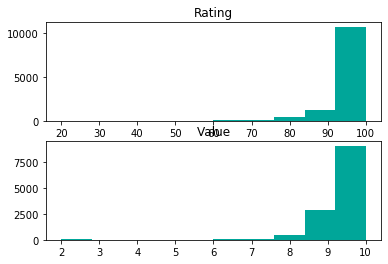

In [19]:
# Checking the distributions of the review ratings columns
bnb_blue = '#00A699'
# Look at ratings distributions
fig,(ax1,ax2) = plt.subplots(2,1)

ax1.hist(airbnb_Mexico.review_scores_rating,color=bnb_blue)
ax1.set_title('Rating')
ax2.hist(airbnb_Mexico.review_scores_value,color=bnb_blue)
ax2.set_title('Value');

In [20]:
# Review Scores are all skewed left. Use median to fill null values

airbnb_Mexico.review_scores_rating.fillna(
    airbnb_Mexico.review_scores_rating.median(),inplace=True)

airbnb_Mexico.review_scores_value.fillna(
    airbnb_Mexico.review_scores_value.median(),inplace=True)


# Other variables of interest
airbnb_Mexico["reviews_per_month"] = airbnb_Mexico["reviews_per_month"].fillna(0)
airbnb_Mexico["host_listings_count"] = airbnb_Mexico["host_listings_count"].fillna(1)

#### Outliers 
We will look at columns that we expect to be most influential on the model. Since our goal is to best serve the "typical" host, we may choose to exclude extreme cases from the model. This is also to check for incorrect data entries. <br>
A commonly used rule says that a data point is an outlier if it is more than 1.5⋅IQR above the third quartile or below the first quartile. We define a criteria of 1.5*IQR.

Variables I consider for the outlier analysis: price, bathrooms, bed, security deposit, minimum nights. We can add more, but these are important variables for our analysis. For now, let's just focus in price.

The price will be transformed to a numeric variable. It's currently a string. Also, we transform the price to US Dollars. ##(Exchange_rate, March 2019: 19.1343 pesos per dollar)

In [21]:
# First, we have to transform the variable price
airbnb_Mexico.price = airbnb_Mexico.price.str[1:-3]
airbnb_Mexico.price = airbnb_Mexico.price.str.replace(",", "")
airbnb_Mexico.price = airbnb_Mexico.price.astype('int64')
airbnb_Mexico.price = airbnb_Mexico.price.divide(19.1343)

# Remove listings with price = 0
airbnb_Mexico = airbnb_Mexico[airbnb_Mexico['price'] != 0]

In [22]:
# Let's keep the original dataset with outliers
airbnb_Mexico_w_outliers= airbnb_Mexico
airbnb_Mexico_w_outliers.shape

(17219, 59)

In [23]:
## Prices
def findOutliers(df, column):
    """
    Returns outliers above the max limit for a column in a dataframe
    Adjust outlier cutoff to q75 + 1.5*iqr to include more data
    ---
    input: DataFrame, column(series),lim_scalar(float)
    output: DataFrame
    """
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    # max limits to be considered an outlier
    max_ = q75 + 1.5 * iqr
    # identify the points
    outlier_mask = [True if x > max_ else False for x in df[column]]
    print('{} outliers found out of {} data points, {}% of the data. {} is the max'.format(
        sum(outlier_mask), len(df[column]),
        100 * (sum(outlier_mask) / len(df[column])),max_))
    return outlier_mask

In [24]:
airbnb_Mexico = airbnb_Mexico[np.logical_not(
    findOutliers(airbnb_Mexico, 'price'))]
airbnb_Mexico.shape

1182 outliers found out of 17219 data points, 6.864510134154132% of the data. 132.2755470542429 is the max


(16037, 59)

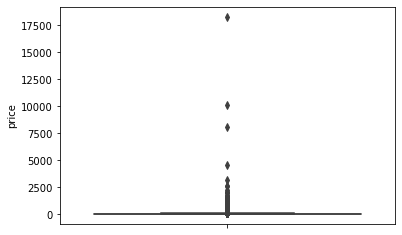

In [25]:
# with outliers
sns.boxplot(y=airbnb_Mexico_w_outliers["price"] )

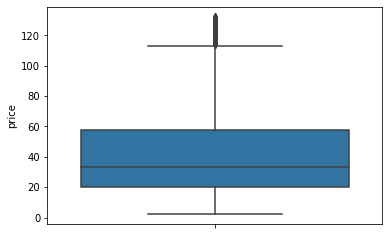

In [26]:
# without outliers
sns.boxplot( y=airbnb_Mexico["price"] )

My final sample will consist in 16037 accomodations, around 93% of the original sample.

## 2. Exploratory Data Analyses

In [27]:
# From now, we are going to use the collapse dataset ('airbnb_Mexico')

airbnb_Mexico['host_since'] = pd.to_datetime(airbnb_Mexico['host_since'])
airbnb_Mexico['first_review'] = pd.to_datetime(airbnb_Mexico['first_review'])

# What is our period of analysis?
print(f"The first host of Airbnbn in Mexico City joined on {min(airbnb_Mexico.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(airbnb_Mexico.host_since).strftime('%d %B %Y')}.")


The first host of Airbnbn in Mexico City joined on 04 April 2009, and the most recent joined on 15 March 2019.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 2.1 Prices

Our variable of analysis is price. Look at the distribution of the prices to get an idea of what the target that we are going to try to predict looks like. <br>


In [28]:
# Visualize price table, changing them to floats and replacing the commas with a blank
prices = airbnb_Mexico.price

# Drop listings with a price of zero
prices = prices[prices!=0]

# Log prices
log_prices = np.log(prices)
airbnb_Mexico['logprices'] = np.log(prices)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


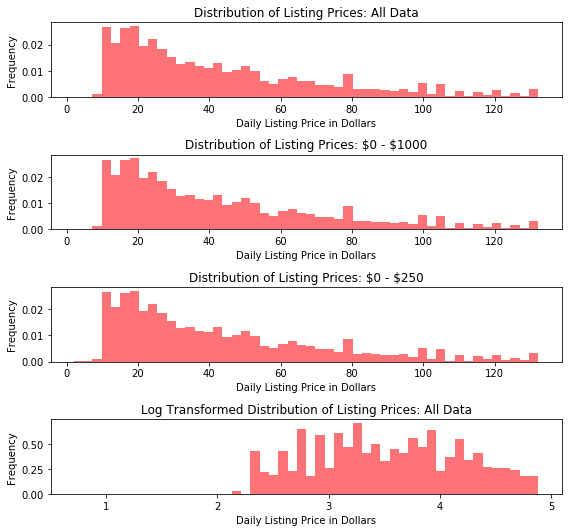

In [29]:
def plot_hist(n, titles, ranges):
   
    fig, ax = plt.subplots(n, figsize = (8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 50, normed = 1, color= bnb_red, alpha = 0.85)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Daily Listing Price in Dollars")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot histograms of price distribution
plot_hist(4, ['Distribution of Listing Prices: All Data', 'Distribution of Listing Prices: \$0 - \$1000', 
               'Distribution of Listing Prices: \$0 - \$250','Log Transformed Distribution of Listing Prices: All Data'], [prices, prices[prices <= 1000], prices[prices < 250],log_prices])

Despite the heavy left skew, log-transforming the prices almost completely normalizes the distribution. We'd would consider it if necessary.

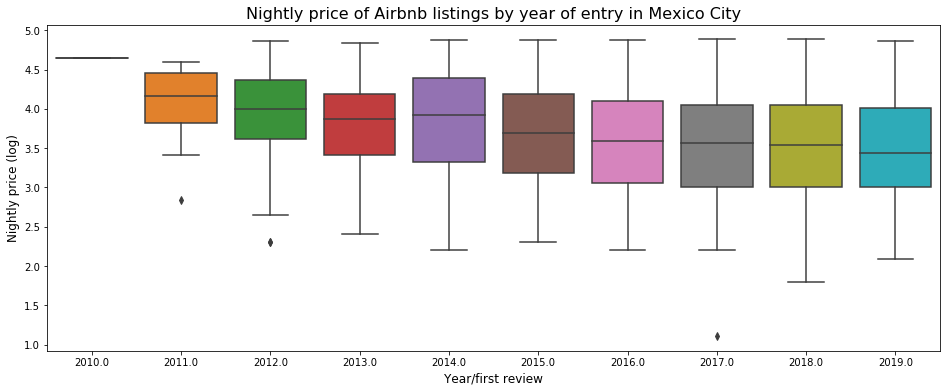

In [30]:
plt.figure(figsize=(16,6))
sns.boxplot(airbnb_Mexico.first_review.dt.year, np.log(airbnb_Mexico.price)) #Price is a variable a create in Excel, since the original price variable is not numeric.
plt.xlabel('Year/first review', fontsize=12)
plt.ylabel('Nightly price (log)', fontsize=12)
plt.title('Nightly price of Airbnb listings by year of entry in Mexico City', fontsize=16)
plt.show()

In term of changes in prices over time, the average price per night for Airbnb listings in Mexico City has decreased to half over the last 10 years. That means that new entrants have to set lower prices in order to be competitive vis a vis old hosts.

### 2.2 Host joining Airbnb

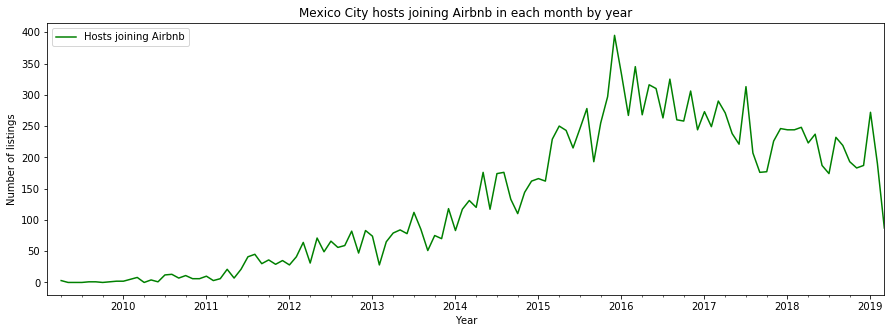

In [31]:
# Let's graph Mexico City hosts joining Airbnb by month,year
plt.figure(figsize=(15,5))
airbnb_Mexico.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='green')
plt.title('Mexico City hosts joining Airbnb in each month by year')
plt.legend(loc='upper left')
plt.xlim('2009-02-03', '2019-03-13') # Limiting to whole months
plt.xlabel('Year')
plt.ylabel('Number of listings')
plt.show()

In [32]:
# Creating dataframes for time series analysis
time_series_host_since = pd.DataFrame(airbnb_Mexico.set_index('host_since').resample('MS').size())
time_series_first_review = pd.DataFrame(airbnb_Mexico.set_index('first_review').resample('MS').size())

# Renaming columns
time_series_host_since = time_series_host_since.rename(columns={0: 'hosts'})
time_series_host_since.index.rename('month', inplace=True)
time_series_first_review = time_series_first_review.rename(columns={0: 'reviews'})
time_series_first_review.index.rename('month', inplace=True)

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose #library to do time series in Python
def decompose_series(data, title=''):   #Define function to detrend series (trend, seasonal and residual)
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(data)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14)
    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')


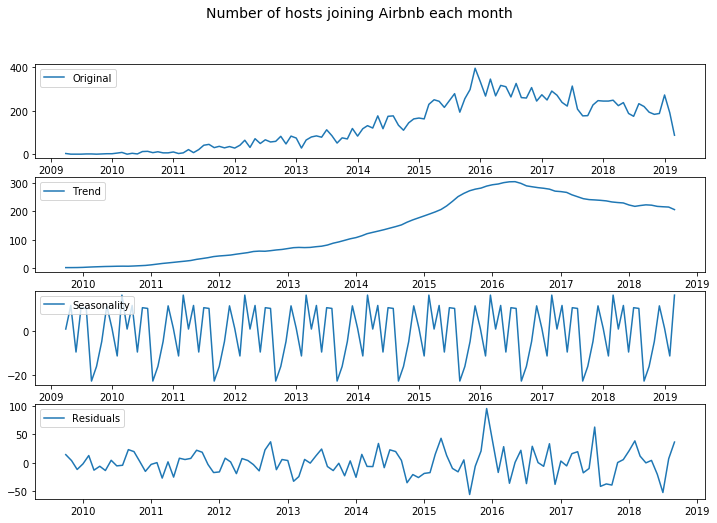

In [34]:
decompose_series(time_series_host_since, title='Number of hosts joining Airbnb each month')


As seen above, there is a clear seasonality. Every year, there are peaks towards hosts joining around 'Semana Santa' and the summer, and the lowest points are in the last quarter of the year. There is a big peak in the number of hosts joining Airbnb between 2014 and 2016 in Mexico City.

### 2.3 Bookings

In [35]:
# A Review Rate of 50% is used to convert reviews to estimated booking (from InsideAirbnb)
airbnb_Mexico['booking'] =airbnb_Mexico['number_of_reviews']*.5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# Check room type
label_colm= 'room_type'

# Drop hotel room
airbnb_Mexico = airbnb_Mexico[airbnb_Mexico.room_type != 'Hotel room']

# Rename shared rooms and private rooms to Rooms
mapping = {'Shared room':'Room', 'Private room':'Room', 'Entire home/apt':'Entire home/apt'}
airbnb_Mexico['room_type'] = airbnb_Mexico['room_type'].map(mapping)

print("Number of room types in original data\n",airbnb_Mexico[label_colm].value_counts())
print("Distribution of room types in original data\n",airbnb_Mexico[label_colm].value_counts()/len(airbnb_Mexico))

Number of room types in original data
 Room               8671
Entire home/apt    7366
Name: room_type, dtype: int64
Distribution of room types in original data
 Room               0.540687
Entire home/apt    0.459313
Name: room_type, dtype: float64


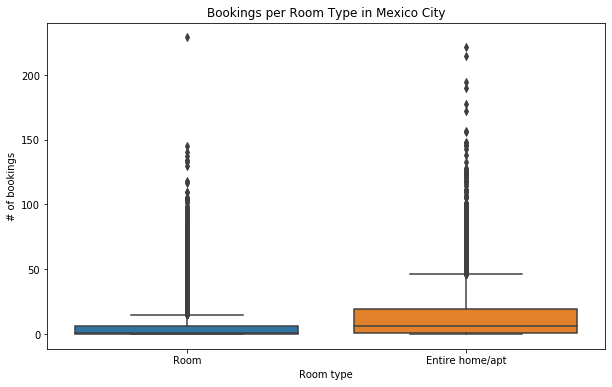

In [37]:
col1 = 'room_type'
col2 = 'booking'

plt.figure(figsize=(10,6))
sns.boxplot(x= col1, y= col2, data=airbnb_Mexico)
plt.title('Bookings per Room Type in Mexico City')
plt.xlabel('Room type')
plt.ylabel('# of bookings')
plt.show()

In [38]:
# Booking per room_type
print('Mean booking count per segment')
booking_count = airbnb_Mexico['booking'].groupby(airbnb_Mexico['room_type_num']).mean()
booking_count

Mean booking count per segment


room_type_num
1     6.231577
2    14.083492
Name: booking, dtype: float64

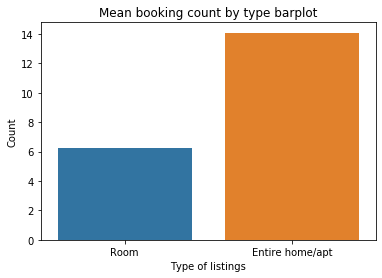

In [39]:
# Plot booking by type, Room = 1, Home = 2
# 
y = [booking_count[1], booking_count[2]]
x = ['Room','Entire home/apt']
ax = sns.barplot(x,y )
ax.set(title='Mean booking count by type barplot', xlabel='Type of listings', ylabel='Count')
plt.show()

In [40]:
# Get the average lenght of stay
#Where no public statements were made about average stays, a value of 3 nights per booking was used.
#If a listing has a higher minimum nights value than the average length of stay, 
# the minimum nights value was used instead.
# Source: InsideAirbnb
# Define function to create 'average lenght of stay'
def f(row):
    if row['minimum_nights'] <=3:
        val = 3
    
    else:
        val = row['minimum_nights']
    return val

airbnb_Mexico['lenght stay'] = airbnb_Mexico.apply(f, axis=1)
airbnb_Mexico['lenght stay'].head(10)


0     3
1     3
2     3
4     3
5     4
6     3
7     3
8     3
9     3
10    3
Name: lenght stay, dtype: int64

In [41]:
# Occupancy rate
# I assume a a value of 3 nights per booking
print('Mean occupancy rate per segment (share)')
airbnb_Mexico['occupancy_rate']=(airbnb_Mexico['booking']*3)/100
airbnb_Mexico['occupancy_rate'].groupby(airbnb_Mexico['room_type_num']).mean()

Mean occupancy rate per segment (share)


room_type_num
1    0.186947
2    0.422505
Name: occupancy_rate, dtype: float64

### 2.4 Geospatial analysis

### What neighborhood?
Inside Airbnb have a geojson file with Mexico's neighborhood, which can be used to do spatial analysis.


In [42]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [44]:
# Import Geographical library
import geopandas as gp #libspatialindex nees to be installed first
import json # library to handle JSON files
import descartes

In [45]:
# Renaming the neighbourhood column
airbnb_Mexico.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
# Importing the Mexico neighbourhood boundary GeoJSON file as a dataframe in geopandas
map_airbnb_Mexico = gp.read_file('neighbourhoods.geojson')
map_airbnb_Mexico.head(20)

,neighbourhood,neighbourhood_group,geometry
0,Azcapotzalco,None,"MULTIPOLYGON (((-99.21002 19.51133, -99.20999 ..."
1,Coyoacán,None,"MULTIPOLYGON (((-99.12189 19.35698, -99.12188 ..."
2,Cuajimalpa de Morelos,None,"MULTIPOLYGON (((-99.25738 19.40112, -99.25698 ..."
3,Gustavo A. Madero,None,"MULTIPOLYGON (((-99.09056 19.50955, -99.09053 ..."
4,Iztacalco,None,"MULTIPOLYGON (((-99.05751 19.40673, -99.05752 ..."
5,Iztapalapa,None,"MULTIPOLYGON (((-99.12200 19.35766, -99.12200 ..."
6,La Magdalena Contreras,None,"MULTIPOLYGON (((-99.20819 19.33674, -99.20859 ..."
7,Milpa Alta,None,"MULTIPOLYGON (((-99.00077 19.22699, -99.00075 ..."
8,Álvaro Obregón,None,"MULTIPOLYGON (((-99.20556 19.30672, -99.20565 ..."
9,Tláhuac,None,"MULTIPOLYGON (((-99.00166 19.22618, -99.00195 ..."


In [46]:
# Dropping the empty column
map_airbnb_Mexico.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and mean price by delegation
delegation_airbnb_Mexico = pd.DataFrame(airbnb_Mexico.groupby('neighbourhood').size())
delegation_airbnb_Mexico.rename(columns={0: 'number_of_listings'}, inplace=True)
delegation_airbnb_Mexico['mean_price'] = airbnb_Mexico.groupby('neighbourhood').price.mean().values
delegation_airbnb_Mexico['number_reviews'] = airbnb_Mexico.groupby('neighbourhood').number_of_reviews.sum().values

# Joining the dataframes
delegation_map_airbnb_Mexico = map_airbnb_Mexico.set_index('neighbourhood').join(delegation_airbnb_Mexico)

delegation_map_airbnb_Mexico.head()

,geometry,number_of_listings,mean_price,number_reviews
neighbourhood,,,,
Azcapotzalco,"MULTIPOLYGON (((-99.21002 19.51133, -99.20999 ...",207,25.770803,1446
Coyoacán,"MULTIPOLYGON (((-99.12189 19.35698, -99.12188 ...",1444,33.135445,20437
Cuajimalpa de Morelos,"MULTIPOLYGON (((-99.25738 19.40112, -99.25698 ...",385,52.222802,2782
Gustavo A. Madero,"MULTIPOLYGON (((-99.09056 19.50955, -99.09053 ...",292,26.349082,3801
Iztacalco,"MULTIPOLYGON (((-99.05751 19.40673, -99.05752 ...",198,23.363829,3053


In [47]:
### To confirm the legend max,min
#delegation_airbnb_Mexico.groupby('neighbourhood')['number_of_listings'].sum() ## Min:0, Max:10,000
#delegation_airbnb_Mexico.groupby('neighbourhood')['mean_price'].mean() ## Min:0, Max:150
delegation_airbnb_Mexico.groupby('neighbourhood')['number_reviews'].sum() ## Min:0, Max:300,000

neighbourhood
Azcapotzalco                1446
Benito Juárez              38152
Coyoacán                   20437
Cuajimalpa de Morelos       2782
Cuauhtémoc                177432
Gustavo A. Madero           3801
Iztacalco                   3053
Iztapalapa                   902
La Magdalena Contreras       844
Miguel Hidalgo             47139
Milpa Alta                     7
Tlalpan                     4439
Tláhuac                       69
Venustiano Carranza         8156
Xochimilco                   350
Álvaro Obregón              6537
Name: number_reviews, dtype: int64

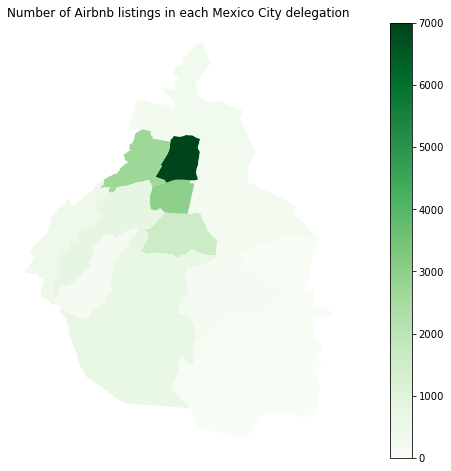

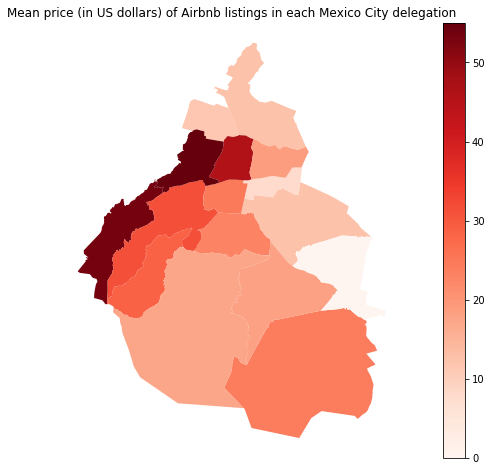

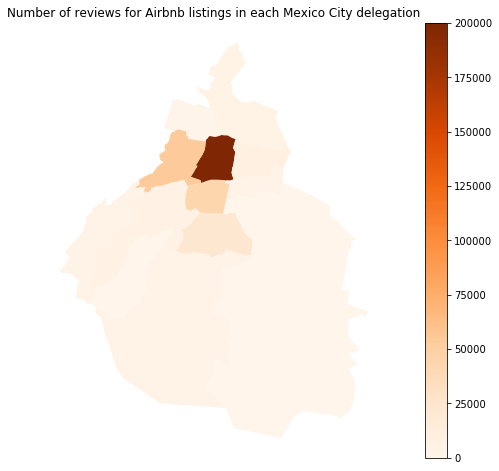

In [48]:
# Plotting the number of listings in each delegation
fig1, ax1 = plt.subplots(1, figsize=(15, 8))
delegation_map_airbnb_Mexico.plot(column='number_of_listings', cmap='Greens',ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Mexico City delegation', fontsize=12)
legend = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=7000))
cbar = fig1.colorbar(legend)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 8))
delegation_map_airbnb_Mexico.plot(column='mean_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Mean price (in US dollars) of Airbnb listings in each Mexico City delegation', fontsize=12)
legend2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=55))
cbar = fig2.colorbar(legend2)
plt.show()

# Plotting the number of reviews in each borough
fig3, ax3 = plt.subplots(1, figsize=(15, 8))
delegation_map_airbnb_Mexico.plot(column='number_reviews', cmap='Oranges', ax=ax3)
ax3.axis('off')
ax3.set_title('Number of reviews for Airbnb listings in each Mexico City delegation', fontsize=12)
legend3 = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=0, vmax=200000))
cbar = fig3.colorbar(legend3)
plt.show()

## HAcer uno de number of reviews

### 2.5 Relevant features

What are the features of Mexico City's airbnbn? Are there more apartmetns, rooms? What's the calculated occupancy rate? Are they single listing or multilisting? These are some of the questions we'd like to answer in this section.

#### 2.5.1 Room type

In [49]:
# Check room type
label_colm= 'room_type'

print("Number of room types in original data\n",airbnb_Mexico[label_colm].value_counts())
print("Distribution of room types in original data\n",airbnb_Mexico[label_colm].value_counts()/len(airbnb_Mexico))

Number of room types in original data
 Room               8671
Entire home/apt    7366
Name: room_type, dtype: int64
Distribution of room types in original data
 Room               0.540687
Entire home/apt    0.459313
Name: room_type, dtype: float64


[Text(0, 0.5, 'Number of listings'), Text(0.5, 0, 'Room type')]

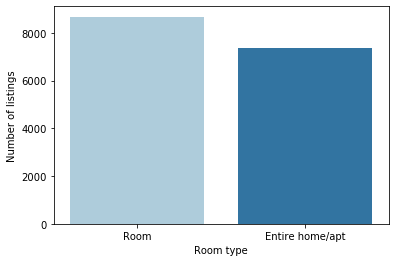

In [50]:
ax = sns.countplot(x='room_type', data=airbnb_Mexico, palette="Paired");
ax.set(xlabel="Room type", ylabel = "Number of listings")

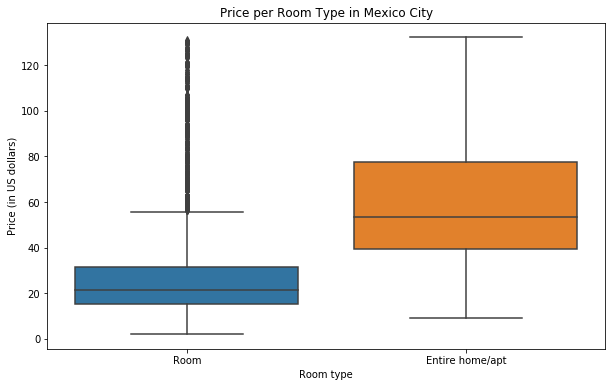

In [51]:
col1 = 'room_type'
col2 = 'price'

plt.figure(figsize=(10,6))
sns.boxplot(x= col1, y= col2, data=airbnb_Mexico)
plt.title('Price per Room Type in Mexico City')
plt.xlabel('Room type')
plt.ylabel('Price (in US dollars)')
plt.show()


In [52]:
airbnb_Mexico.shape

(16037, 63)

For comparison purposes, we also provide the price distribution per property type in Mexico City.

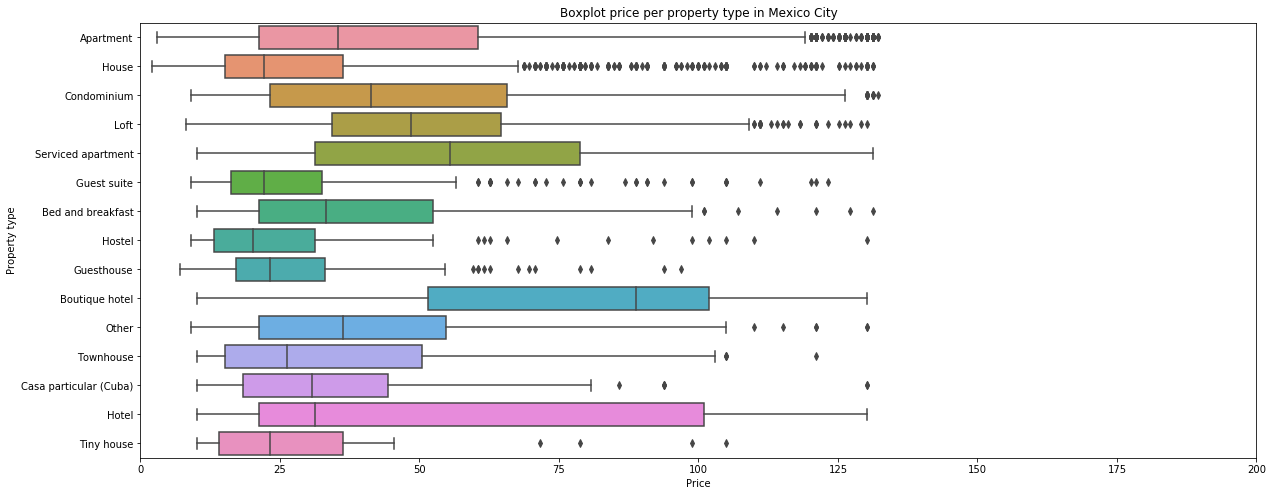

In [53]:
# Boxplot price per property type in Mexico city.
col1 = 'property_type_num'
col2 = 'price'

plt.figure(figsize=(20,8))
ax=sns.boxplot(x= col2, y= col1, data=airbnb_Mexico, whis=1.5,orient="h",)
plt.title('Boxplot price per property type in Mexico City')
plt.xlabel('Price')
plt.ylabel('Property type')
ax.set_yticklabels(list(property_dict.keys()))
plt.xlim(0,200)
plt.show()

#### 2.5.2  Availability

In [54]:
# High availability is defined as more than 60 days per year. Sounds reasonable (or 90)
# Relevant variable is 
#if >60, then 1, if <=60 then 0
airbnb_Mexico['availability_365'].unique()

bins = [0, 60, np.inf]
names = ['Low Availability', 'High Availability']
airbnb_Mexico['availability'] = pd.cut(airbnb_Mexico['availability_365'], bins, labels=names)
print(airbnb_Mexico['availability'].value_counts())

High Availability    13102
Low Availability      1100
Name: availability, dtype: int64


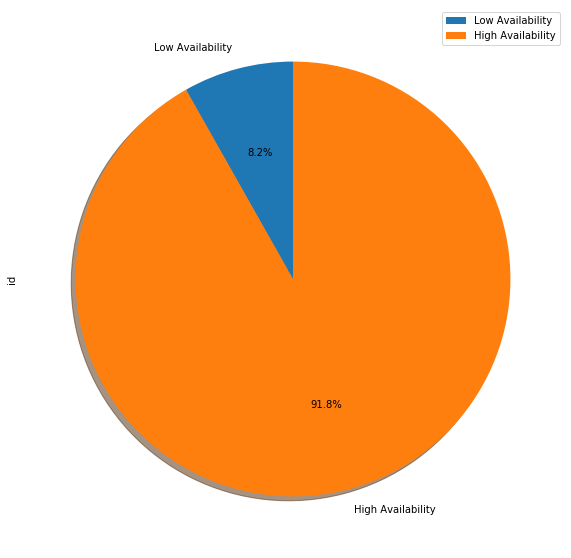

In [55]:
# Pie chart of 'availability'
airbnb_Mexico.groupby(['availability']).sum().plot(kind='pie', y='id',shadow = True,startangle=90,figsize=(15,10),autopct='%1.1f%%')

In [56]:
# Availability
# One hot encode
n_type_dummies = pd.get_dummies(airbnb_Mexico.availability,
                                   prefix='avai')

# # Merge with df
airbnb_Mexico = airbnb_Mexico.merge(n_type_dummies,
                                                    left_index=True,
                                                    right_index=True)

Mexico City's Airbnbn accomodations are of high availability (more than 60 days available per year).

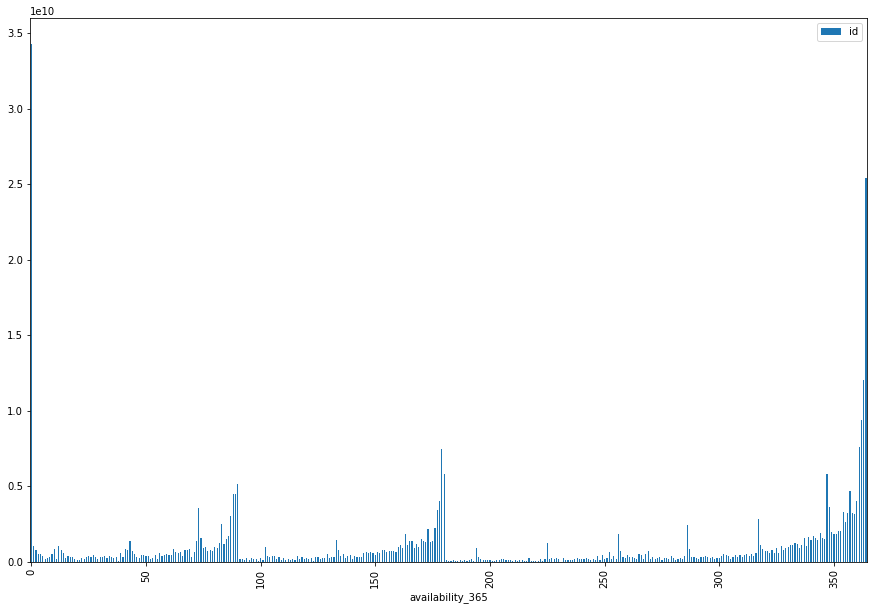

In [57]:
# Distribution of availability by listings
airbnb_Mexico.groupby(['availability_365']).sum().plot(kind='bar', y='id',xticks=([0,50,100,150,200,250,300,350]), figsize=(15,10))


#### 2.5.3 Listings per Host

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '26'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '35'),
 Text(0, 0, '37'),
 Text(0, 0, '42'),
 Text(0, 0, '44'),
 Text(0, 0, '48')]

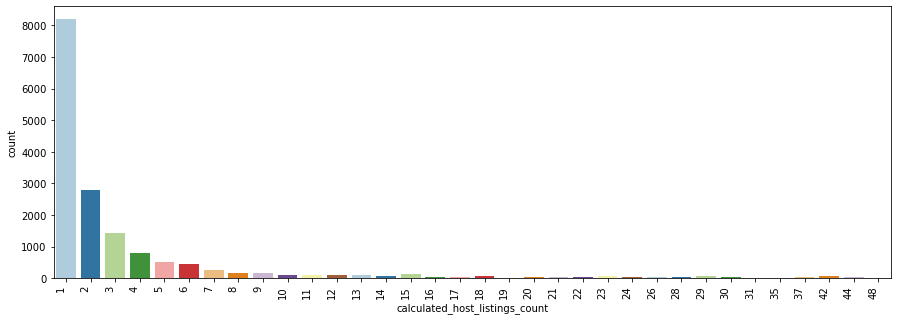

In [58]:
# Define the distribution of listings by host
plt.figure(figsize=(15,5))
chart = sns.countplot(x='calculated_host_listings_count', data=airbnb_Mexico,  palette="Paired")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')

In [59]:
# Check listings by host
airbnb_Mexico['calculated_host_listings_count'].nunique()
count_list = airbnb_Mexico['calculated_host_listings_count'].value_counts()

In [60]:
# Define function to separate single/multilisting hosts
def f(row):
    if row['calculated_host_listings_count'] == 1:
        val = "Single Listing"
    
    else:
        val = "Multilisting"
    return val

airbnb_Mexico['calculated_host_listings_count_num'] = airbnb_Mexico.apply(f, axis=1)

In [61]:
# Listings by type (total numbers)
print("Number of listings by type in original data\n",airbnb_Mexico['calculated_host_listings_count_num'].value_counts())

Number of listings by type in original data
 Single Listing    8194
Multilisting      7843
Name: calculated_host_listings_count_num, dtype: int64


In [62]:
# Share of listings by type (percentage)
print("Distribution of listings by type in original data\n",airbnb_Mexico['calculated_host_listings_count_num'].value_counts()/len(airbnb_Mexico))

Distribution of listings by type in original data
 Single Listing    0.510943
Multilisting      0.489057
Name: calculated_host_listings_count_num, dtype: float64


In [63]:
# Type
# One hot encode
n_type_dummies = pd.get_dummies(airbnb_Mexico.calculated_host_listings_count_num,
                                   prefix='type')

# # Merge with df
airbnb_Mexico = airbnb_Mexico.merge(n_type_dummies,
                                                    left_index=True,
                                                    right_index=True)

### 3. Data Preparation

To get a feel for what is going on in the data and what we expect to be important/influential features in the model, we'll look at summary statistics and visualizations of the data before building a model



In [64]:
airbnb_Mexico.columns

Index(['id', 'host_id', 'host_name', 'host_since', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood', 'city', 'zipcode',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'security_deposit', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_since_num', 'room_type_num', 'room_Entire home/apt',
       'room_Private room', 'room_Shared room', 'neigh_Azcapotzalco',
       'neigh_Benito Juárez', 'neigh_Coyoacán', 'neigh_Cua

### Relevant variables

In [65]:
airbnb_Mexico.columns

Index(['id', 'host_id', 'host_name', 'host_since', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood', 'city', 'zipcode',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'security_deposit', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_since_num', 'room_type_num', 'room_Entire home/apt',
       'room_Private room', 'room_Shared room', 'neigh_Azcapotzalco',
       'neigh_Benito Juárez', 'neigh_Coyoacán', 'neigh_Cua

In [66]:
drop_cols = ['id','host_id', 'host_name', 'host_total_listings_count' , 'host_since', 'room_type','first_review','room_Shared room','room_type_num' ]
airbnb_Mexico=airbnb_Mexico.drop(drop_cols, axis=1)


#### Correlation Matrix
We will build a linear regression model using all of the data and use this to help identify multicollinearity in the data along with features that do not have any predictive power

In [67]:
# try to drop all strings
airbnb_Mexico = airbnb_Mexico.select_dtypes(exclude=['object', 'category'])
#airbnb_Mexico = airbnb_Mexico.dropna()

X = airbnb_Mexico.drop(['price','logprices'] ,axis=1)
y = airbnb_Mexico['price']
#y = np.log(untransformed_y.astype(float))

In [68]:
airbnb_Mexico['logprices'].head(10)

0     3.228534
1     4.644407
2     4.520450
4     4.594436
5     3.620800
6     4.452188
7     3.921681
8     4.563317
9     4.016427
10    4.087301
Name: logprices, dtype: float64

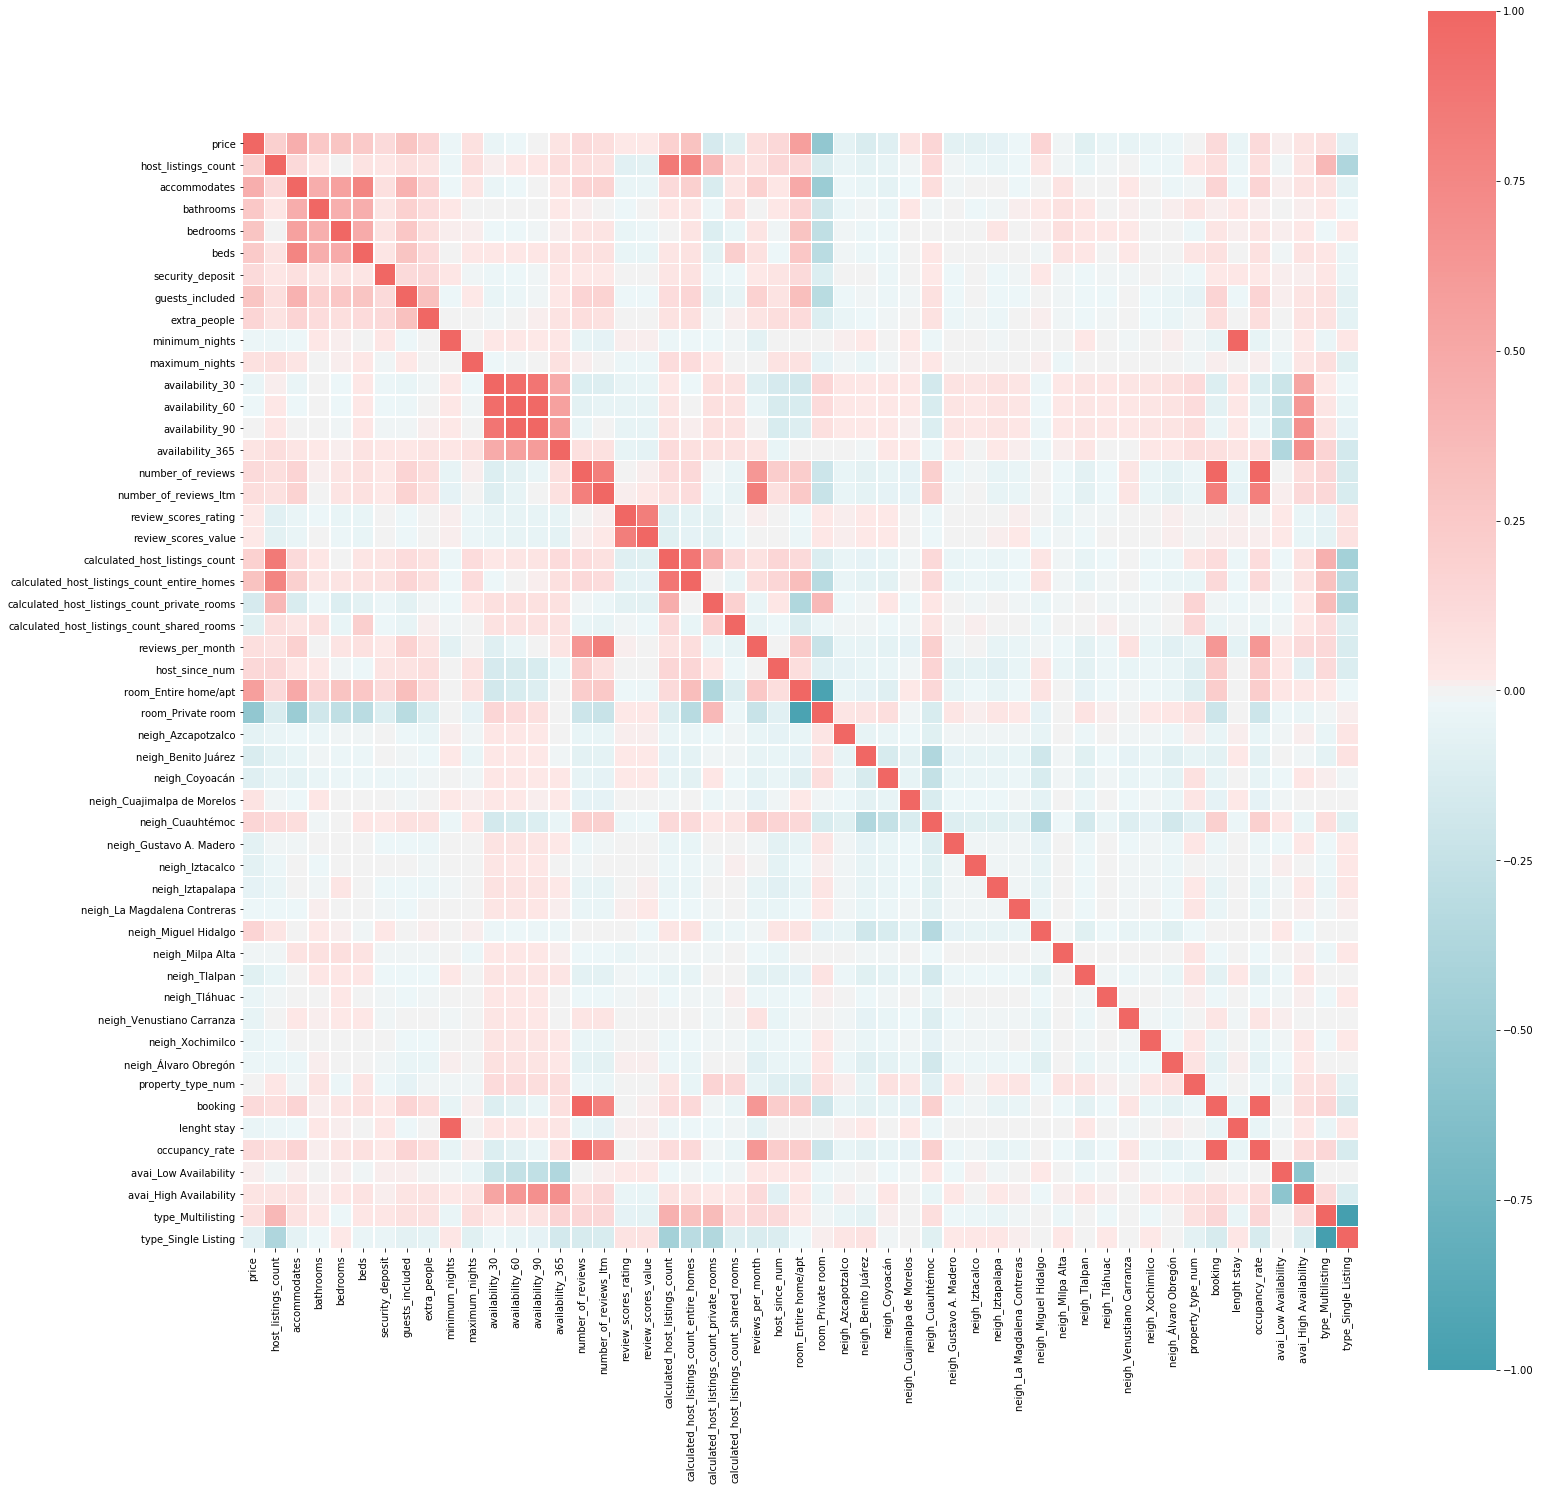

In [69]:
# Look at a heatmap of the target and feature matrix
# Identify potential multicollinearities between features

bnb_cmap = sns.diverging_palette(210,
                                 13,
                                 s=81,
                                 l=61,
                                 sep=3,
                                 n=16,
                                 as_cmap=True)
plt.figure(figsize=(25,25))
sns.heatmap(pd.concat([y,X],axis=1).corr(),
            cmap=bnb_cmap,
            annot=False,
            vmin=-1,
            vmax=1, 
            linewidths=.5,
            square=True);

#### Train test split
80% to train and validate the model and 20% to test the final model

In [70]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import \
    train_test_split, GridSearchCV, KFold, cross_val_score

# Set scalar
scaler = StandardScaler()

# Set intercept column to a nonzero value
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print("train", len(X_train), "test",len(X_test))




train 12829 test 3208


### 4. Modelling

### 4.1 Price Analysis: Linear regression

#### Ordinary Least Squares with sklearn
First try an Ordinary Least Squares linear regression model

Use the sklearn package to get a full list of summary statistics for the mdoel

#### With the whole dataset: no split, with outliers

In [71]:
# try to drop all strings
drop_cols = ['id','host_id', 'host_total_listings_count' , 'host_since','room_Shared room','room_type_num' ]

airbnb_Mexico_w_outliers=airbnb_Mexico_w_outliers.drop(drop_cols, axis=1)

airbnb_Mexico_w_outliers = airbnb_Mexico_w_outliers.select_dtypes(exclude=['object', 'category'])

# First, we run the original model without any split and considering outliers
X_out = airbnb_Mexico_w_outliers.drop(['price'] ,axis=1)
y_out = airbnb_Mexico_w_outliers['price']


# Set scalar
scaler = StandardScaler()

X_scaled_out = scaler.fit_transform(X_out)



In [72]:
model_out_Mex = LinearRegression()  
model_out_Mex.fit(X_scaled_out, y_out) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
#To retrieve the intercept:
print(model_out_Mex.intercept_)
#For retrieving the slope:
print(model_out_Mex.coef_)

60.455513736691636
[ 7.24100698e+00  3.14388530e+01  1.69253530e+01  5.98617051e-01
 -1.63687886e+01  1.06078280e+01 -3.60973825e+00  6.12932697e+00
 -1.58367648e+00  2.66991942e+00  1.09495547e+01  5.01199473e+00
 -1.26349340e+01  5.52108802e+00 -2.98720998e+00  2.78869965e+00
  3.65452980e+00 -4.80374768e-01 -1.36113536e+12  1.24013323e+12
  5.65874986e+11  9.32155344e+10 -1.07482880e+01 -2.50193520e+00
  7.18061919e+00 -1.99748081e+00  4.29022730e+12  1.42484453e+13
  1.09193495e+13  6.02918148e+12  1.89897515e+13  5.07852255e+12
  4.17932935e+12  4.22000994e+12  3.33409626e+12  1.43148169e+13
  1.10632001e+12  7.58087897e+12  1.61873347e+12  4.73343270e+12
  2.90504274e+12  8.04223634e+12  2.12176433e+00]


In [74]:
print(f"Accuracy: {model_out_Mex.score(X_scaled_out, y_out)}")


Accuracy: 0.05589983447599344


In [75]:
y_pred_lm_out = model_out_Mex.predict(X_scaled_out)

In [76]:
print('OLS model R^2 on out-of-sample data with outliers: {:f}'.format(
    model_out_Mex.score(X_scaled_out, y_out)))

OLS model R^2 on out-of-sample data with outliers: 0.055900


Text(0.5, 1.0, 'Actual vs Predicted (OLS) with outliers')

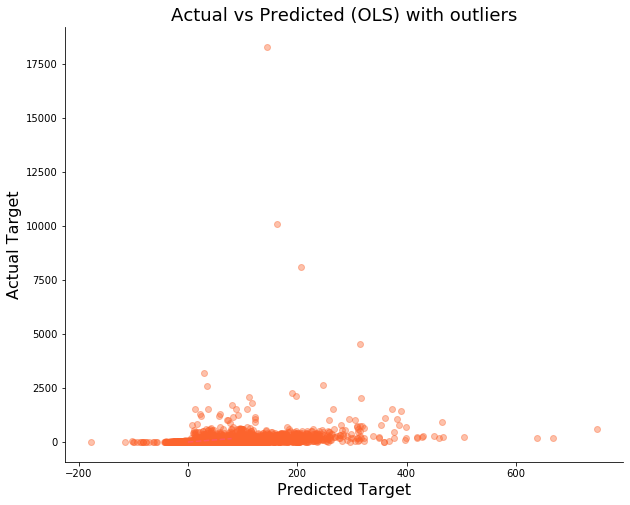

In [77]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0, 80], [0, 160], '--', c=bnb_red)
plt.scatter(y_pred_lm_out, y_out, color=bnb_orange, alpha=0.4)
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
sns.despine()
plt.ylabel('Actual Target', size=16)
plt.xlabel('Predicted Target', size=16)
plt.title('Actual vs Predicted (OLS) with outliers', size=18)

#### Linear regression with split (train/test dataset) and without outliers

In [78]:
model_Mex = LinearRegression()  
model_Mex.fit(X_train_scaled, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
#To retrieve the intercept:
print(model_Mex.intercept_)
#For retrieving the slope:
print(model_Mex.coef_)

42.104799953534084
[ 1.62359840e+00  7.03768273e+00  2.94925516e+00  1.05418721e+00
 -3.49664370e+00  1.02158593e+00  6.11775953e-01  1.16203906e+00
 -3.84920092e+01  5.05276010e-01  1.94036978e+00  6.35503579e-01
 -3.55059740e-01  4.79853974e-01  1.31961684e+13 -9.26405178e-01
  7.14351155e-01  7.84937714e-01  1.47363893e+12 -1.29854292e+12
 -6.68287017e+11 -1.16293702e+11 -2.67387229e+00  8.09286415e-01
  1.50444631e+01  2.90835552e+00  6.54121113e+11  2.14683870e+12
  1.62188896e+12  8.65880834e+11  2.79298170e+12  7.62274801e+11
  6.34841290e+11  6.56016265e+11  4.85279567e+11  2.05848458e+12
  1.51460461e+11  1.11975100e+12  2.31251369e+11  6.92771265e+11
  4.30281518e+11  1.20399206e+12  1.55483358e+00 -2.34513202e+12
  3.74122124e+01 -1.08510364e+13  3.22204933e-01 -5.05265771e-02
 -9.38813525e+11 -9.38813525e+11]


In [80]:
print(f"Train accuracy: {model_Mex.score(X_train_scaled, y_train)}")
print(f"Test accuracy: {model_Mex.score(X_test_scaled, y_test)}")

Train accuracy: 0.47565493766880534
Test accuracy: -6.396119278342266e+19


In [81]:
y_pred_lm = model_Mex.predict(X_test_scaled)

In [82]:
print('OLS model R^2 on out-of-sample data: {:f}'.format(
    model_Mex.score(X_test_scaled, y_test)))

OLS model R^2 on out-of-sample data: -63961192783422660608.000000


Text(0.5, 1.0, 'Actual vs Predicted (OLS)')

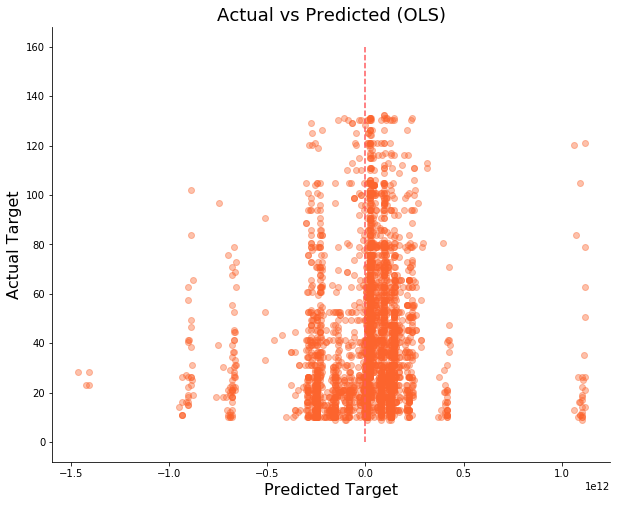

In [83]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0, 80], [0, 160], '--', c=bnb_red)
plt.scatter(y_pred_lm, y_test, color=bnb_orange, alpha=0.4)
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
sns.despine()
plt.ylabel('Actual Target', size=16)
plt.xlabel('Predicted Target', size=16)
plt.title('Actual vs Predicted (OLS)', size=18)


In [84]:
resid_lm = y_test - y_pred_lm  # Calculate residuals


Text(0.5, 1.0, 'Distribution of Residuals')

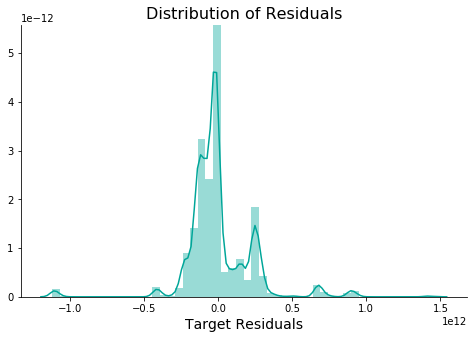

In [85]:
# Plot distribution of residuals
plt.figure(figsize=(8, 5))
sns.distplot(resid_lm,color=bnb_blue)
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)

Not good fitness. Therefore, we need to try with polynomial features.

### Linear Regression with Polynomial Features¶


Polynomial Regression is an effective tool in feature engineering. It can identify features that should be transformed to a higher degree or potentially important feature interactions



In [86]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

degree = 2

poly = PolynomialFeatures(degree=degree)

# Fit polynomial features and transform on training data
X_train_poly = poly.fit_transform(X_train.values)

# Transform test data
X_test_poly = poly.transform(X_test.values)

# Instantiate polynomial features with linear regression
# and fit to training data
lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
cross_val_score(lm_poly, X_train_poly, y_train, scoring='r2')


array([ 4.97578332e-01,  5.07467908e-01, -7.63306283e-02, -1.04271616e+00,
       -7.20417679e+02])

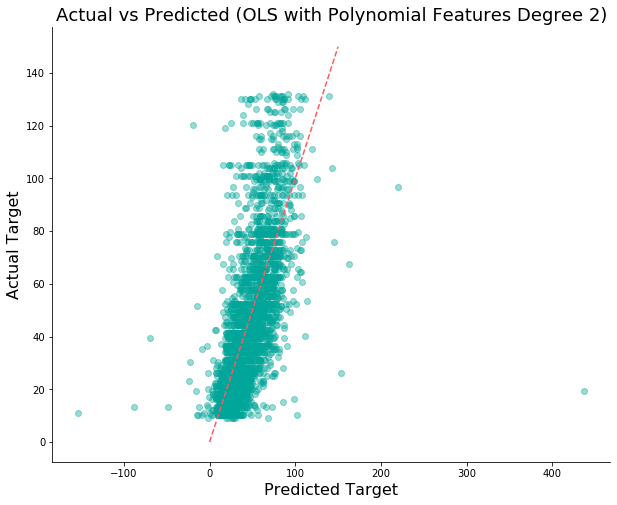

In [88]:
y_pred_poly = lm_poly.predict(X_test_poly)

# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0, 150], [0, 150], '--', c=bnb_red)
plt.scatter(y_pred_poly, y_test, color=bnb_blue, alpha=0.4)
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
sns.despine()
plt.ylabel('Actual Target', size=16)
plt.xlabel('Predicted Target', size=16)
plt.title('Actual vs Predicted (OLS with Polynomial Features Degree 2)', size=18)
plt.savefig('./OLS with Polynomial Features Degree 2.png')

### 4.2 Price Analysis: Tuned model, Random Forest regressor

### Initial model

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


GS = RandomForestRegressor(random_state=30)
GS.fit(X_train_scaled, y_train)

print('train acc\n',GS.score(X_train_scaled, y_train))
print('test acc\n',GS.score(X_test_scaled, y_test),'\n\n')

train acc
 0.9455132721795995
test acc
 0.5862263989116334 




### RFRegressor Grid

In [90]:
param_grid = {'max_depth': [10,20,30], 'n_estimators':[50,100,200], 'ccp_alpha': [0, 0.0001], 'min_samples_split': [2, 5, 10]}


RF_model = RandomForestRegressor(random_state=30)
GSR = GridSearchCV(RF_model, param_grid, cv=3)
GSR.fit(X_train_scaled, y_train)

print('train acc RF (the coefficient of determination R^2 of the prediction)\n',GSR.score(X_train_scaled, y_train))
print('test acc RF (the coefficient of determination R^2 of the prediction)\n',GSR.score(X_test_scaled, y_test),'\n\n')

train acc RF (the coefficient of determination R^2 of the prediction)
 0.9464811464627195
test acc RF (the coefficient of determination R^2 of the prediction)
 0.5878734671064318 




In [91]:
par = GSR.cv_results_['params']
print ('\n Best params\n',GSR.best_params_)
print ('\n Best score \n',round(GSR.best_score_,4))
print ('\n Test params: \n')
i=0
for line in par:
    i+=1
    print('Split', i,'|',line, '| Mean score:', round(GSR.cv_results_['mean_test_score'][i-1],5))
    
print('\nrank_test_score\n',GSR.cv_results_['rank_test_score'])
print('\nmean_test_score\n',GSR.cv_results_['mean_test_score'])
#print('\n',metrics.classification_report(y_test, RF_test_prads))
print ('\n Best Estimator \n',(GSR.best_estimator_))


 Best params
 {'ccp_alpha': 0, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

 Best score 
 0.5944

 Test params: 

Split 1 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50} | Mean score: 0.581
Split 2 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} | Mean score: 0.5831
Split 3 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200} | Mean score: 0.5843
Split 4 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50} | Mean score: 0.58062
Split 5 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} | Mean score: 0.58269
Split 6 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200} | Mean score: 0.58392
Split 7 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50} | Mean score: 0.57897
Split 8 | {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100} | Mean

According to these results, it's better to use the mode we got from the GridSearch CV, as it has a better accuracy for our test data.

### RFRegressor Manual

In [92]:
RF_model = RandomForestRegressor(random_state=30, max_depth = 26, n_estimators=200, ccp_alpha= 0.00025, min_samples_split= 2)
RFR_man = RF_model
RFR_man.fit(X_train_scaled, y_train)

print('train acc RF (the coefficient of determination R^2 of the prediction)\n',RFR_man.score(X_train_scaled, y_train))
print('test acc RF (the coefficient of determination R^2 of the prediction)\n',RFR_man.score(X_test_scaled, y_test),'\n\n')

train acc RF (the coefficient of determination R^2 of the prediction)
 0.9452850905576661
test acc RF (the coefficient of determination R^2 of the prediction)
 0.5893221496860631 




In [93]:
print ('\n Best params\n',RFR_man.get_params)
print ('\n Best score \n',round(RFR_man.score(X_test_scaled, y_test),4))


 Best params
 <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.00025, criterion='mse',
                      max_depth=26, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)>

 Best score 
 0.5893


#### Visualizations (Base model)

In [94]:
print(GS.get_params)

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)>


In [95]:
feature_importances_df = pd.DataFrame({"feature": X.columns[:len(GS.feature_importances_)],"feature_score": GS.feature_importances_ })
feature_importances_df = feature_importances_df.sort_values(by='feature_score', ascending=True)

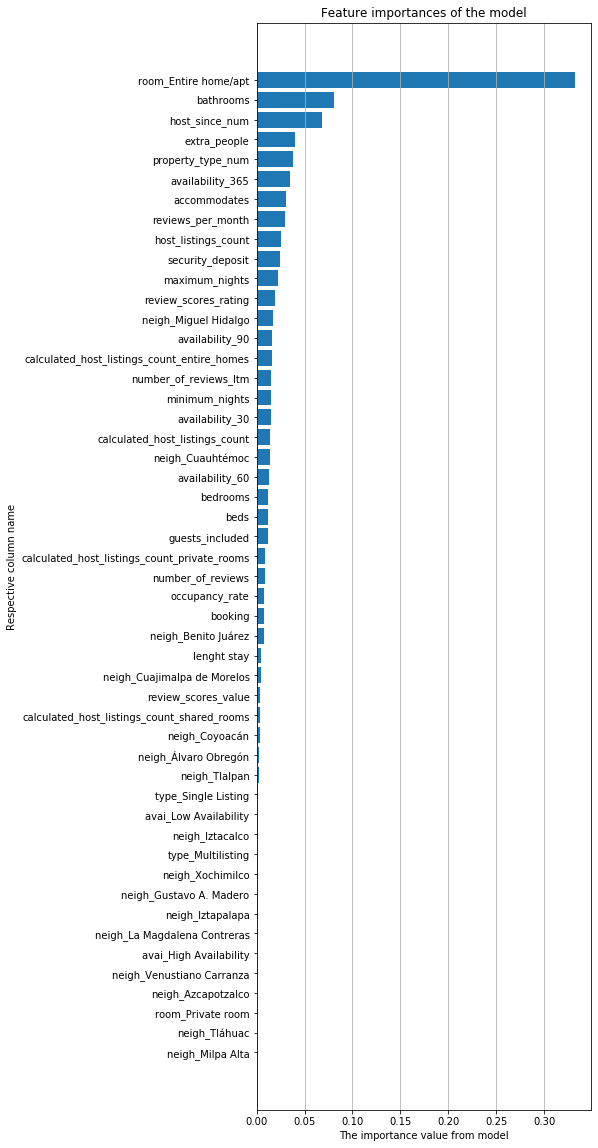

The type_Single Listing is the most important feature according to our model with a score of 0.332554858287767


In [96]:
y = feature_importances_df['feature_score']
x = feature_importances_df['feature']
plt.figure(figsize=(6,20))
plt.barh(x, y,)
plt.grid(axis='x')
plt.xlabel('The importance value from model')
plt.ylabel('Respective column name')
plt.title('Feature importances of the model')
plt.xticks()
plt.savefig('./features.png')
plt.show()
print('The', feature_importances_df.max().feature ,'is the most important feature according to our model with a score of', max(GS.feature_importances_))

In [97]:
preds = GS.predict(X_test_scaled)
pred_analysis = pd.DataFrame({"pred": preds, "true": y_test, "diff": preds - y_test.values})

In [98]:
pred_analysis.describe()

,pred,true,diff
count,3208.000000,3208.000000,3208.000000
mean,42.766895,42.105224,0.661671
std,22.079406,28.241958,18.154649
min,10.622808,9.093617,-94.661420
25%,23.445266,20.173197,-6.020210
50%,37.885629,34.336244,3.337201
75%,58.532452,57.540647,10.186680
max,121.545079,132.223285,69.161140


In [99]:
pred_analysis.head()

,pred,true,diff
16602,22.791009,12.124823,10.666186
11797,58.728043,75.727881,-16.999838
13927,17.755549,36.322207,-18.566658
16937,69.179954,95.901078,-26.721124
6296,30.254569,25.242627,5.011942


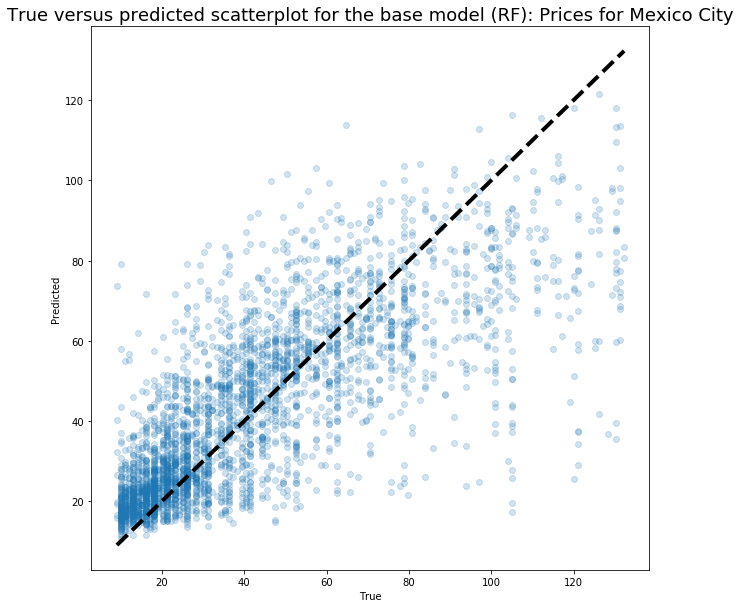

In [100]:
fig, ax = plt.subplots(figsize=(10,10))

y = pred_analysis['true']
ax.scatter(y, pred_analysis['pred'], alpha=0.2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('True versus predicted scatterplot for the base model (RF): Prices for Mexico City', size=18)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.savefig('./prediction.png')
plt.show()

#### Visualizations (Best model)

In [101]:
feature_importances_df = pd.DataFrame({"feature": X.columns[:len(RFR_man.feature_importances_)],"feature_score": RFR_man.feature_importances_ })
feature_importances_df = feature_importances_df.sort_values(by='feature_score', ascending=True)



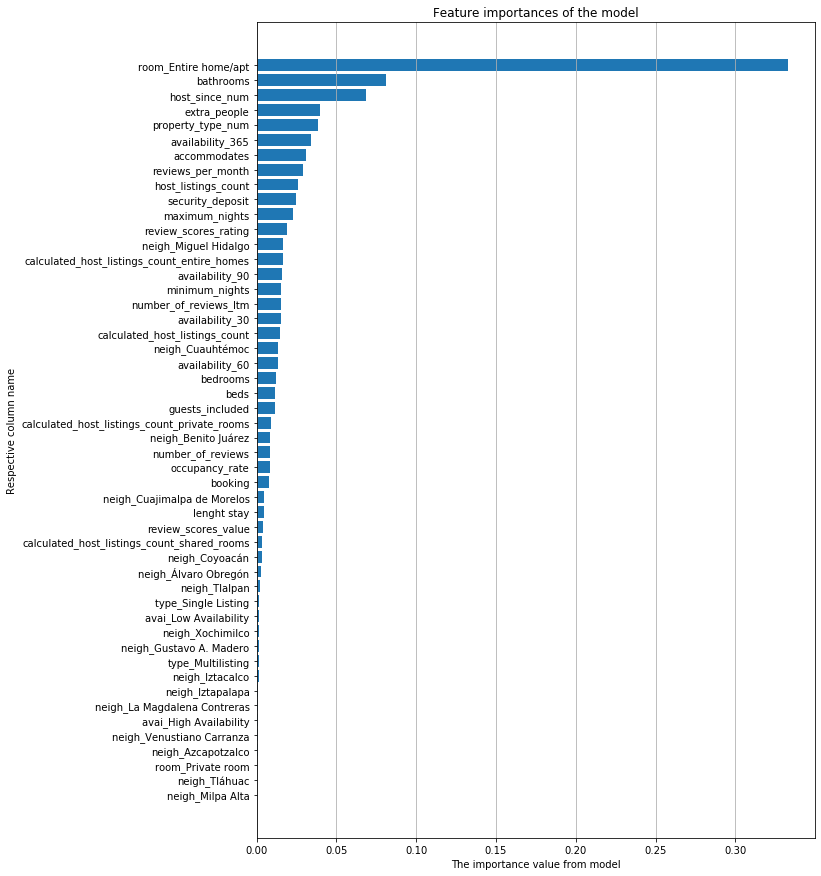

In [102]:
y = feature_importances_df['feature_score']
x = feature_importances_df['feature']

plt.figure(figsize=(10,15))
plt.barh(x, y,)
plt.grid(axis='x')
plt.xlabel('The importance value from model')
plt.ylabel('Respective column name')
plt.title('Feature importances of the model')
plt.xticks()
plt.savefig('./features2.png',bbox_inches='tight', pad_inches=0)
plt.show()


In [103]:
preds = RFR_man.predict(X_test_scaled)
pred_analysis = pd.DataFrame({"pred": preds, "true": y_test, "diff": preds - y_test.values})

In [104]:
pred_analysis.describe()

,pred,true,diff
count,3208.000000,3208.000000,3208.000000
mean,42.794745,42.105224,0.689521
std,22.073048,28.241958,18.085476
min,10.625577,9.093617,-96.389022
25%,23.503820,20.173197,-5.810548
50%,37.865146,34.336244,3.375564
75%,58.655347,57.540647,10.049471
max,120.206231,132.223285,68.950886


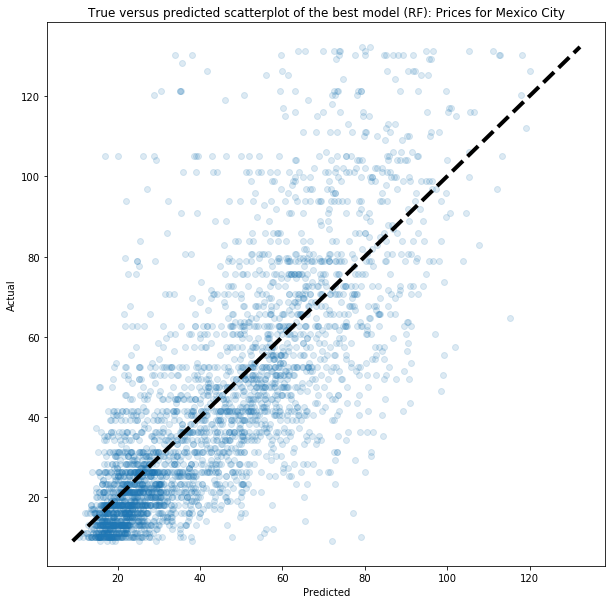

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

y = pred_analysis['true']
ax.scatter( pred_analysis['pred'],pred_analysis['true'], alpha=0.15)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('True versus predicted scatterplot of the best model (RF): Prices for Mexico City')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig('./prediction.png')
plt.show()